In [208]:
%%capture

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence

from torchtext.vocab import build_vocab_from_iterator
import nltk
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction
from nltk.translate.meteor_score import meteor_score
from bert_score import score as bert_score_fn
import matplotlib.pyplot as plt
import random
import re
from collections import Counter
from tqdm import tqdm
from tqdm.notebook import tqdm
import gdown
from functools import partial

import pickle
import numpy as np
import pandas as pd
import time
import os
import sys
import spacy
import ast

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

In [209]:

if torch.backends.mps.is_available():
    DEVICE = 'mps'  # Apple GPU 사용
elif torch.cuda.is_available():
    DEVICE = 'cuda'  # NVIDIA GPU 사용
else:
    DEVICE = 'cpu'   # CPU fallback

print(DEVICE)

mps


In [210]:
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False


In [211]:
# data 다운
train_path = 'Cooking_Dataset/train.csv'
dev_path = 'Cooking_Dataset/dev.csv'
test_path = 'Cooking_Dataset/test.csv'


if not os.path.exists('Cooking_Dataset'):
    os.makedirs('Cooking_Dataset')
    print("Downloading Dataset")
    gdown.download("https://drive.google.com/uc?id=1uZdYjvllt0dSdKKtrCgKHUk-APKdmeNU", train_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1SAMbkdtjGBYgojqobiwe7ZmnEq7SiGsF", dev_path, quiet=False)
    gdown.download("https://drive.google.com/uc?id=1v6Rr2et_4WA5mRwwlRxtLhn38pbmr9Yr", test_path, quiet=False)


train_df = pd.read_csv(train_path)
dev_df = pd.read_csv(dev_path)
test_df = pd.read_csv(test_path)

# 데이터 확인
print(f"Train data size: {len(train_df)}")
print(f"Dev data size: {len(dev_df)}")
print(f"Test data size: {len(test_df)}")
print("\nTrain data sample:")
print(train_df.head())
#No-Bake Nut Cookies
# ["1 c. firmly packed brown sugar", "1/2 c. evaporated milk", "1/2 tsp. vanilla", "1/2 c. broken nuts (pecans)", "2 Tbsp. butter or margarine", "3 1/2 c. bite size shredded rice biscuits"]
# ["In a heavy 2-quart saucepan, mix brown sugar, nuts, evaporated milk and butter or margarine.", "Stir over medium heat until mixture bubbles all over top.", "Boil and stir 5 minutes more. Take off heat.", "Stir in vanilla and cereal; mix well.", "Using 2 teaspoons, drop and shape into 30 clusters on wax paper.", "Let stand until firm, about 30 minutes."]

Train data size: 162899
Dev data size: 1065
Test data size: 1081

Train data sample:
                      Title  \
0       No-Bake Nut Cookies   
1               Creamy Corn   
2      Reeses Cups(Candy)     
3  Cheeseburger Potato Soup   
4       Rhubarb Coffee Cake   

                                         Ingredients  \
0  ["1 c. firmly packed brown sugar", "1/2 c. eva...   
1  ["2 (16 oz.) pkg. frozen corn", "1 (8 oz.) pkg...   
2  ["1 c. peanut butter", "3/4 c. graham cracker ...   
3  ["6 baking potatoes", "1 lb. of extra lean gro...   
4  ["1 1/2 c. sugar", "1/2 c. butter", "1 egg", "...   

                                              Recipe  
0  ["In a heavy 2-quart saucepan, mix brown sugar...  
1  ["In a slow cooker, combine all ingredients. C...  
2  ["Combine first four ingredients and press in ...  
3  ["Wash potatoes; prick several times with a fo...  
4  ["Cream sugar and butter.", "Add egg and beat ...  


In [212]:
spacy_en = spacy.load('en_core_web_sm')

def tokenizer_ingredient_baseline(text):
    """
    Baseline 전처리: 소문자화 + lemmatization + 간단한 필터링
    - stopword 제거 있음
    - 숫자, 구두점 제거 있음
    - 불필요한 복잡 전처리 없음
    """
    import ast
    text_list = ast.literal_eval(text)
    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.like_num or token.is_stop:
                    continue
                tokens.append(token.lemma_.strip())  # 기본 lemmatization만 유지
    return tokens



def tokenizer_recipe_baseline(text):
    """
    Recipe 전처리: 소문자화 + lemmatization만 수행 (구두점, stopword, 숫자는 유지)
    - 조리 순서, 동사 등 자연스러운 문장 흐름을 보존해야 하므로 간단한 전처리만 적용
    """
    tokens = []
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        doc = spacy_en(text.lower())
        for token in doc:
            # 너무 공격적인 필터링은 하지 않음
            if token.is_space:
                continue
            tokens.append(token.lemma_.strip())
    return tokens





def tokenizer_ingredient_extension(text, remove_stopwords=True, lemmatize=True):
    text_list = ast.literal_eval(text)  # 문자열 → 리스트로 변환
    unit_keywords = {
        'c', 'cup', 'cups', 'tbsp', 'tablespoon', 'tsp', 'teaspoon',
        'oz', 'ounce', 'lb', 'pound', 'g', 'kg', 'mg',
        'pt', 'qt', 'gal', 'ml', 'l',
        'package', 'pkg', 'envelope', 'box', 'bag', 'jar', 'can', 'cans', 'bottle',
        'dash', 'pinch', 'slice', 'slices', 'head', 'inch', 'inches',
        'stick', 'sticks', 'small', 'medium', 'large'
    }

    tokens = []

    with spacy_en.select_pipes(disable=["parser", "ner"]):
        for item in text_list:
            doc = spacy_en(item.lower())
            for token in doc:
                if token.is_punct or token.is_space:
                    continue
                if token.like_num:
                    continue
                if token.text.strip(".") in unit_keywords:
                    continue
                if remove_stopwords and token.is_stop:
                    continue
                if token.pos_ != "NOUN":  # 명사만
                    continue

                tokens.append(token.lemma_.strip() if lemmatize else token.text.strip())
    return tokens

def tokenizer_recipe_extension(text):  # 디폴트: lemmatize 안 함
    text_list = ast.literal_eval(text)
    tokens = []

    # tagger는 유지해서 lemma 써도 warning 없음
    with spacy_en.select_pipes(disable=["parser", "ner", "tagger"]):
        for item in text_list:
            doc = spacy_en(item.lower())  # 소문자화
            for token in doc:
                if token.is_punct or token.is_space:
                    continue  # 마침표, 쉼표 제거
                if token.like_num:  # 숫자 유지
                    tokens.append(token.text.strip())
                    continue
                
                tokens.append(token.text.strip())
                
    return tokens




In [213]:
ing = train_df.iloc[1,2]
print(ing)
print(tokenizer_recipe_extension(ing))

["In a slow cooker, combine all ingredients. Cover and cook on low for 4 hours or until heated through and cheese is melted. Stir well before serving. Yields 6 servings."]
['in', 'a', 'slow', 'cooker', 'combine', 'all', 'ingredients', 'cover', 'and', 'cook', 'on', 'low', 'for', '4', 'hours', 'or', 'until', 'heated', 'through', 'and', 'cheese', 'is', 'melted', 'stir', 'well', 'before', 'serving', 'yields', '6', 'servings']


/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


In [214]:
def build_vocab(token_lists, min_freq=2):
    # vocab 생성: 자주 등장하는 단어만 포함 + 특수 토큰 정의
    vocab = build_vocab_from_iterator(
        token_lists,  # 토큰 리스트들을 직접 반복
        min_freq=min_freq,  # 최소 등장 빈도
        specials=['<pad>', '<sos>', '<eos>', '<unk>']  # 특수 토큰 추가
    )
    vocab.set_default_index(vocab['<unk>'])  # 없는 단어는 <unk>로 처리
    return vocab

In [215]:
def load_or_tokenize_data(model_type, train_df):
    if "extension" in model_type:
        tokenizer_ingredient = tokenizer_ingredient_extension
        tokenizer_recipe = tokenizer_recipe_extension
        ingredient_cache_path = "tokens/ingredient_tokens_ext.pkl"
        recipe_cache_path = "tokens/recipe_tokens_ext.pkl"
        ingredient_cache_download = "https://drive.google.com/uc?id=1uXHVNptWeQgkv0uSRLaKYF1SFpcng5cF"
        recipe_cache_dowload = "https://drive.google.com/uc?id=1qXrpx_nxt8p-ErDPq5w4AkrqNahHki_o"
    else:
        tokenizer_ingredient = tokenizer_ingredient_baseline
        tokenizer_recipe = tokenizer_recipe_baseline
        ingredient_cache_path = "tokens/ingredient_tokens.pkl"
        recipe_cache_path = "tokens/recipe_tokens.pkl"
        ingredient_cache_download = "https://drive.google.com/uc?id=..."
        recipe_cache_dowload = "https://drive.google.com/uc?id=..."

    if not os.path.exists('tokens'):
        os.makedirs('tokens')
        gdown.download(ingredient_cache_download, ingredient_cache_path, quiet=False)
        gdown.download(recipe_cache_dowload, recipe_cache_path, quiet=False)

    try:
        with open(ingredient_cache_path, "rb") as f:
            ingredient_token_lists = pickle.load(f)
        with open(recipe_cache_path, "rb") as f:
            recipe_token_lists = pickle.load(f)
        print("✅ Loaded token cache.")
    except FileNotFoundError:
        print("⚠️ No cache → Tokenizing...")
        ingredient_token_lists = [tokenizer_ingredient(text) for text in tqdm(train_df['Ingredients'], desc="Tokenizing ingredients")]
        recipe_token_lists = [tokenizer_recipe(text) for text in tqdm(train_df['Recipe'], desc="Tokenizing recipes")]
        with open(ingredient_cache_path, "wb") as f:
            pickle.dump(ingredient_token_lists, f)
        with open(recipe_cache_path, "wb") as f:
            pickle.dump(recipe_token_lists, f)

    ingredient_vocab = build_vocab(ingredient_token_lists, min_freq=1)
    recipe_vocab = build_vocab(recipe_token_lists)
    return ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe


In [216]:
class CustomDataset(Dataset):
    def __init__(self, df, ingredient_vocab, recipe_vocab,
                 tokenizer_ingredient, tokenizer_recipe):
        self.df = df
        self.ingredient_vocab = ingredient_vocab
        self.recipe_vocab = recipe_vocab
        self.tokenizer_ingredient = tokenizer_ingredient
        self.tokenizer_recipe = tokenizer_recipe

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        ingredient_tokens = self.tokenizer_ingredient(self.df.iloc[idx]["Ingredients"])
        recipe_tokens = self.tokenizer_recipe(self.df.iloc[idx]["Recipe"])

        ingredient_ids = [self.ingredient_vocab[token] for token in ingredient_tokens]
        recipe_ids = [self.recipe_vocab['<sos>']] + \
                     [self.recipe_vocab[token] for token in recipe_tokens] + \
                     [self.recipe_vocab['<eos>']]

        return torch.tensor(ingredient_ids), torch.tensor(recipe_ids)


In [217]:
def collate_fn(batch, ingredient_vocab, recipe_vocab, device):
    ingredients, recipes = zip(*batch)
    ingredients_padded = pad_sequence(ingredients, batch_first=True, padding_value=ingredient_vocab['<pad>'])
    recipes_padded = pad_sequence(recipes, batch_first=True, padding_value=recipe_vocab['<pad>'])
    return ingredients_padded.to(device), recipes_padded.to(device)

In [218]:
class Encoder_GRU(nn.Module):
    def __init__(self, ingredient_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio,
                 embedding_weights=None, freeze=False):
        super().__init__()
        # 임베딩
        if embedding_weights is not None:
            self.embedding = nn.Embedding.from_pretrained(embedding_weights, freeze=freeze)
        else:
            self.embedding = nn.Embedding(ingredient_vocab_size, embedding_dim)
        

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, src):
        # src : [batch_size, src_len]
        src = src.long() 
        # 임베딩
        embedded = self.dropout(self.embedding(src))
        # embedded : [batch_size, src_len, hidden_dim]

        # gru 통과
        outputs, hidden = self.gru(embedded) # h0를 따로 주지 않으면, 디폴트로 h0가 0로 초기화되서 들어감
        # outputs: [batch_size, src_len, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        return outputs,hidden

class Decoder_GRU(nn.Module):
    def __init__(self, recipe_vocab_size, embedding_dim, hidden_dim, n_layers, dropout_ratio):
        super().__init__()

        self.recipe_vocab_size = recipe_vocab_size
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio

        # 임베딩
        self.embedding = nn.Embedding(recipe_vocab_size, embedding_dim)

        # GRU 레이어
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.gru = nn.GRU(embedding_dim,
                          hidden_dim,
                          n_layers,
                          dropout=dropout_ratio if n_layers>1 else 0,
                          batch_first=True)

        # fc 레이어
        self.fc_out = nn.Linear(hidden_dim, recipe_vocab_size)

        # 드롭아웃
        self.dropout = nn.Dropout(dropout_ratio)

    def forward(self, input, hidden):
        input = input.long()
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # GRU 통과
        outputs, hidden = self.gru(embedded,hidden)
        # outputs: [batch_size, 단어의 개수=1, hidden_size]
        # hidden: [n_layers, batch_size, hidden_size]

        # fc 통과
        prediction = self.fc_out(outputs.squeeze(1))
        # prediction: [batch_size, vocab_size]

        return prediction, hidden


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder, device, use_attention):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.device = device
        self.use_attention = use_attention

    def forward(self, src, target=None, teacher_forcing_ratio=0.5, max_len=50):
        # 인코더
        encoder_outputs, hidden = self.encoder(src)
        batch_size = src.size(0)
        vocab_size = self.decoder.recipe_vocab_size

        # 추론 모드
        if target is None:
            outputs = []
            input_token = torch.tensor([recipe_vocab['<sos>']] * batch_size).to(self.device).long()

            for _ in range(max_len):
                if self.use_attention:
                    output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
                else:
                    output, hidden = self.decoder(input_token, hidden)
                top1 = output.argmax(1)
                outputs.append(top1.unsqueeze(1))
                input_token = top1

            return torch.cat(outputs, dim=1)  # [batch_size, max_len]

        # 학습 모드
        target = target.long()
        target_len = target.shape[1]
        outputs = torch.zeros(batch_size, target_len, vocab_size).to(self.device)
        input_token = target[:, 0].long()  # <sos>

        for t in range(1, target_len):
            if self.use_attention:
                output, hidden, _ = self.decoder(input_token, hidden, encoder_outputs)
            else:
                output, hidden = self.decoder(input_token, hidden)
            outputs[:, t, :] = output
            top1 = output.argmax(1)
            teacher_force = random.random() < teacher_forcing_ratio
            input_token = target[:, t].long() if teacher_force else top1

        return outputs

import torch.nn.functional as F
    

# Define a decoder with attention mechanism using PyTorch's nn.Module
class AttnDecoderRNN(nn.Module):
    def __init__(self, recipe_vocab_size,embedding_dim, hidden_size, n_layers, dropout_ratio):
        # Initialize the base nn.Module class
        super(AttnDecoderRNN, self).__init__()

        # Save parameters
        self.recipe_vocab_size = recipe_vocab_size              # Size of the output vocabulary
        self.embedding_dim = embedding_dim                  # Dropout probability
        self.hidden_size = hidden_size              # Size of the hidden state in GRU
        self.n_layers = n_layers
        self.dropout_ratio = dropout_ratio
                  

        # Define layers
        self.embedding = nn.Embedding(self.recipe_vocab_size, self.hidden_size)  # Converts word indices to dense vectors
        self.dropout = nn.Dropout(self.dropout_ratio)                          # Applies dropout for regularization
        self.gru = nn.GRU(self.hidden_size, self.hidden_size, self.n_layers, dropout=self.dropout_ratio if self.n_layers>1 else 0, batch_first=True)
             # GRU to process the embedded inputs
        self.out = nn.Linear(self.hidden_size * 2, self.recipe_vocab_size)       # Linear layer for generating final output

    def forward(self, input, hidden, encoder_outputs):
        input = input.long() 
        # input : [batch_size]
        input = input.unsqueeze(1)
        # input : [batch_size, 단어의 개수=1]

        # 임베딩
        embedded = self.dropout(self.embedding(input))
        # embedded : [batch_size, 단어의 개수=1, hidden_dim]

        # Pass through GRU
        output, hidden = self.gru(embedded, hidden)  # output: [batch, 1, hidden_size]

        # Compute attention weights using dot-product attention:
        # hidden[-1]: [batch, hidden_size]
        # encoder_outputs: [batch, src_len, hidden_size]
    
        attn_weights = F.softmax(
            torch.bmm(output, encoder_outputs.transpose(1, 2)), # [batch, 1, hidden_size] x [batch, hidden_size, src_len]
            dim=-1
        )  # [batch, 1, src_len]

        # Apply attention weights to encoder outputs to get context vector
        # attn_weights: (1, 1, max_length)
        # encoder_outputs.unsqueeze(0): (1, max_length, hidden_size)
        attn_output = torch.bmm(attn_weights, encoder_outputs)  # [batch, 1, hidden_size]

        # Concatenate attention output and decoder hidden state
        concat_output = torch.cat((output, attn_output), dim=2)  # [batch, 1, hidden*2]

        # Pass through linear layer and softmax to get output word probabilities
        output = F.log_softmax(self.out(concat_output).squeeze(1), dim=1)  # [batch, vocab_size]

        # Return output word distribution, updated hidden state, and attention weights
        return output, hidden, attn_weights.squeeze(1)

    



In [219]:
def build_glove_embedding_matrix(glove_path, vocab, glove_dim=100):
    print("🔎 Loading GloVe vectors...")
    glove_embeddings = {}

    with open(glove_path, 'r', encoding="utf-8") as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            vector = torch.tensor(list(map(float, values[1:])))
            glove_embeddings[word] = vector

    # Initialize matrix with random vectors
    embedding_matrix = torch.randn(len(vocab), glove_dim)

    for word, idx in vocab.get_stoi().items():
        if word in glove_embeddings:
            embedding_matrix[idx] = glove_embeddings[word]

    print("✅ GloVe embedding matrix created.")
    return embedding_matrix


In [ ]:
def loss_epoch(model, dataloader, criterion, optimizer=None, teacher_forcing_ratio=0.5, max_len=50):
    rloss = 0
    batch_losses = []

    for i, (src_batch, trg_batch) in enumerate(tqdm(dataloader, desc="Training batches", leave=False)):
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, trg_batch, teacher_forcing_ratio=teacher_forcing_ratio, max_len=max_len)
        output_dim = output.shape[-1]
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)

        loss = criterion(output, trg)

        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        batch_loss = loss.item() * src_batch.size(0)
        batch_losses.append(batch_loss)
        rloss += batch_loss

        tqdm.write(f"[Batch {i+1}/{len(dataloader)}] Loss: {loss.item():.4f}")

    avg_loss = rloss / len(dataloader.dataset)
    return avg_loss, batch_losses


def Train(model, train_loader, val_loader, criterion, optimizer,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path, TEACHER_FORCING_RATIO, MAX_LEN, **kwargs
          ):
    """
    이어서 학습할 수 있게 start_epoch와 best_val_loss를 인자로 받음
    """
    if "LR_STEP" in kwargs:
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=kwargs["LR_STEP"], gamma=kwargs["LR_GAMMA"])
    else:
        scheduler = None
    loss_history = {"train_epoch": [], "train_iter": [], "val_epoch": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    for ep in tqdm(range(EPOCHS), desc="Epochs"):
        print(f"Epoch {ep+1}/{EPOCHS}")

        ep_start_time = time.time()

        # Training
        model.train()
        train_epoch_loss, train_batch_loss = loss_epoch(
            model, train_loader, criterion, optimizer, 
            teacher_forcing_ratio=TEACHER_FORCING_RATIO,
            max_len=MAX_LEN
        )
        loss_history["train_epoch"].append(train_epoch_loss)
        loss_history["train_iter"].append(train_batch_loss)

        # Validation
        model.eval()
        with torch.no_grad():
            val_loss, _ = loss_epoch(
                model, val_loader, criterion, optimizer=None,
                teacher_forcing_ratio=0.0,
                max_len=MAX_LEN
            )
            loss_history["val_epoch"].append(val_loss)

        ep_elapsed_time = time.time() - ep_start_time

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            # 디렉토리 없으면 생성
            os.makedirs("results", exist_ok=True)
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": ep,
                "val_loss": val_loss,
                "train_loss": train_epoch_loss,  # train_loss 저장
            }, save_model_path)
            print("Best model saved!")

        if scheduler is not None:
            scheduler.step()

        print(f"Train Loss: {train_epoch_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
    train_elapsed_time = time.time() - train_start_time
    # Save training history
    
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,   
        "TRAIN_RATIO": TRAIN_RATIO,
        "train_elapsed_time": train_elapsed_time,
        "LR_STEP": kwargs["LR_STEP"] if "LR_STEP" in kwargs else None,
        "LR_GAMMA": kwargs["LR_GAMMA"] if "LR_GAMMA" in kwargs else None
    }, save_history_path)
    total_iterations = sum(len(batch_list) for batch_list in loss_history["train_iter"])
    print(f"Total number of iteration : {total_iterations}")
    print(f"Training Completed! Total Time: {train_elapsed_time:.2f}s")
    return loss_history



def Test(model, test_loader, criterion, recipe_vocab, MAX_LEN):
    model.eval()

    with torch.no_grad():
        test_loss, _ = loss_epoch(model, test_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0, max_len=MAX_LEN)

    # 평가 지표 계산
    bleu_score, meteor_avg, bertscore_f1 = compute_metrics(model, test_loader, recipe_vocab)

    print(f"Test Loss      : {test_loss:.4f}")
    print(f"BLEU-4 Score   : {bleu_score:.4f}")
    print(f"METEOR Score   : {meteor_avg:.4f}")
    print(f"BERTScore (F1) : {bertscore_f1:.4f}")

    return test_loss, bleu_score, meteor_avg, bertscore_f1



def compute_metrics(model, dataloader, recipe_vocab, max_len=50):
    """
    테스트셋 전체에서 BLEU, METEOR, BERTScore 계산

    Returns:
        bleu_score (float), meteor_avg (float), bertscore_f1 (float)
    """
    model.eval()
    smoothie = SmoothingFunction().method4

    ref_list = []
    hyp_list = []

    with torch.no_grad():
        for src_batch, trg_batch in tqdm(dataloader, desc="Evaluating Metrics"):
            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 기준으로 자르기
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                pred_words = [recipe_vocab.get_itos()[idx] for idx in pred_tokens]
                trg_words = [recipe_vocab.get_itos()[idx] for idx in trg_tokens]

                ref_list.append(trg_words)
                hyp_list.append(pred_words)

    # BLEU-4
    bleu_score = corpus_bleu([[ref] for ref in ref_list], hyp_list, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smoothie) 

    # METEOR
    meteor_scores = [meteor_score([ref], hyp) for ref, hyp in zip(ref_list, hyp_list)]
    meteor_avg = sum(meteor_scores) / len(meteor_scores)

    # BERTScore
    refs = [" ".join(ref) for ref in ref_list]
    hyps = [" ".join(hyp) for hyp in hyp_list]
    _, _, f1 = bert_score_fn(hyps, refs, lang='en', verbose=False)
    bertscore_f1 = f1.mean().item()

    return bleu_score, meteor_avg, bertscore_f1


def plot_loss_epoch(name, loss_history):
    plt.figure(figsize=(6, 3))

    train_loss = loss_history["train_epoch"]
    val_loss = loss_history["val_epoch"]

    plt.plot(range(1, len(train_loss) + 1), train_loss, label="Train Loss", color="blue")
    plt.plot(range(1, len(val_loss) + 1), val_loss, label="Validation Loss", color="red")

    plt.xlabel("Epoch", fontsize=10)
    plt.ylabel("Loss", fontsize=10)
    plt.title(f"Loss per Epoch: {name}", fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_loss_iter(**models_histories):
    plt.figure(figsize=(10, 6))
    for model_name, history in models_histories.items():
        train_iter_losses = history.get("train_iter", [])
        if train_iter_losses:
            plt.plot(train_iter_losses, label=model_name)
        else:
            print(f"[경고] {model_name}에 train_iter 데이터가 없습니다.")

    plt.title("Training Iteration Loss")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [221]:
def main(model_type: str, config: dict,
         train_df, dev_df, test_df,
         glove_path: str = "./glove.6B.100d.txt"):

    # 1. Tokenize & Vocab
    ingredient_token_lists, recipe_token_lists, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe = load_or_tokenize_data(model_type, train_df)

    # 2. GloVe embedding 적용 (config에 "embedding_weights" 키가 있는 경우)
    embedding_weights = None
    freeze_embedding = False
    if config.get("use_glove", False):
        ingredient_embedding_matrix = build_glove_embedding_matrix(glove_path, ingredient_vocab, glove_dim=config["EMBED_DIM"])
        embedding_weights = ingredient_embedding_matrix
    else:
        embedding_weights = None

    # 3. Dataset & DataLoader
    BATCH_SIZE = config.get("BATCH_SIZE", 64)
    train_dataset = CustomDataset(train_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    dev_dataset = CustomDataset(dev_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)
    test_dataset = CustomDataset(test_df, ingredient_vocab, recipe_vocab, tokenizer_ingredient, tokenizer_recipe)

    collate = partial(collate_fn, ingredient_vocab=ingredient_vocab, recipe_vocab=recipe_vocab, device=DEVICE)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate)
    dev_loader = DataLoader(dev_dataset, batch_size=64, shuffle=False, collate_fn=collate)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate)

    # 4. Model 구성
    INPUT_DIM = len(ingredient_vocab)
    OUTPUT_DIM = len(recipe_vocab)
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])

    encoder = Encoder_GRU(
        ingredient_vocab_size=INPUT_DIM,
        embedding_dim=config["EMBED_DIM"],
        hidden_dim=config["HIDDEN_DIM"],
        n_layers=config["N_LAYERS"],
        dropout_ratio=config["DROPOUT"],
        embedding_weights=embedding_weights,
        freeze=freeze_embedding
    )

    if config["USE_ATTENTION"]:
        decoder = AttnDecoderRNN(
            recipe_vocab_size=OUTPUT_DIM,
            embedding_dim=config["EMBED_DIM"],
            hidden_size=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"]
        )
    else:
        decoder = Decoder_GRU(
            recipe_vocab_size=OUTPUT_DIM,
            embedding_dim=config["EMBED_DIM"],
            hidden_dim=config["HIDDEN_DIM"],
            n_layers=config["N_LAYERS"],
            dropout_ratio=config["DROPOUT"]
        )

    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)

    # 5. 학습 또는 로드
    save_model_path = f"results/{model_type}.pt"
    save_history_path = f"results/{model_type}_history.pt"

    if config["new_model_train"]:
        print(f"Training model: {model_type}")
        optimizer = optim.Adam(model.parameters(), lr=config["LR"])
        loss_history = Train(
            model=model,
            train_loader=train_loader,
            val_loader=dev_loader,
            criterion=criterion,
            optimizer=optimizer,
            EPOCHS=config["EPOCHS"],
            BATCH_SIZE=BATCH_SIZE,
            TRAIN_RATIO=1.0,
            save_model_path=save_model_path,
            save_history_path=save_history_path,
            TEACHER_FORCING_RATIO=config["TEACHER_FORCING_RATIO"],
            MAX_LEN=config["MAX_LEN"],
            LR_STEP=config.get("LR_STEP"),
            LR_GAMMA=config.get("LR_GAMMA")
        )
        return model, encoder, decoder, loss_history, save_model_path, save_history_path, test_loader, recipe_vocab
    else:
        return model, encoder, decoder, None, save_model_path, save_history_path, test_loader, recipe_vocab


In [222]:
# 하이퍼파라미터 저장
experiment_configs = {
    "baseline1": {
        "new_model_train" : True,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": False,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "baseline2": {
        "new_model_train" : True,
        "EMBED_DIM": 128,
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 1,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 50,
        "BATCH_SIZE": 64
    },
    "mild_extension1": {
        "new_model_train" : False,
        "EMBED_DIM": 256,
        "HIDDEN_DIM": 512,
        "DROPOUT": 0.5,
        "N_LAYERS": 3,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 100,
        "LR_STEP": 1,         
        "LR_GAMMA": 0.7,
        "BATCH_SIZE": 64
    },
    "mild_extension2": {
        "new_model_train" : False,
        "EMBED_DIM": 100,  # GloVe 6B 100D와 일치
        "HIDDEN_DIM": 256,
        "DROPOUT": 0.5,
        "N_LAYERS": 3,
        "LR": 0.001,
        "EPOCHS": 5,
        "USE_ATTENTION": True,
        "TEACHER_FORCING_RATIO": 0.7,
        "MAX_LEN": 100,
        "LR_STEP": 1,         
        "LR_GAMMA": 0.7,
        "use_glove": True,   
        "freeze_embedding": False,
        "BATCH_SIZE": 64
    }
}

In [223]:
import os

def evaluate_and_report(model_type, config, encoder, decoder, save_model_path, save_history_path,
                        test_loader, criterion, recipe_vocab):
    if not os.path.exists(save_model_path) or not os.path.exists(save_history_path):
        print(f"⚠️ Checkpoint for {model_type} not found. Skipping evaluation.\n")
        return

    # 1. 모델 불러오기
    model = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
    checkpoint = torch.load(save_model_path, map_location=DEVICE)
    checkpoint2 = torch.load(save_history_path, map_location=DEVICE)
    model.load_state_dict(checkpoint["model_state_dict"])

    # 2. 학습 정보 출력
    best_epoch = checkpoint["epoch"] + 1
    best_train_loss = checkpoint["train_loss"]
    best_val_loss = checkpoint["val_loss"]
    train_elapsed_time = checkpoint2["train_elapsed_time"]
    print(f"📌 {model_type} | Epoch {best_epoch} | Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
    print(f"⏱️ Training Time: {train_elapsed_time:.2f}s\n")

    # 3. 그래프 그리기
    loss_history = checkpoint2["loss_history"]
    plot_loss_epoch(model_type, loss_history)

    # 4. 테스트
    Test(model, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"])


In [ ]:
for model_type, config in experiment_configs.items():
    print(f"=== Evaluating {model_type} ===")
    model, encoder, decoder, _, save_model_path, save_history_path, test_loader, recipe_vocab = main(
        model_type, config, train_df, dev_df, test_df
    )
    criterion = nn.CrossEntropyLoss(ignore_index=recipe_vocab['<pad>'])
    evaluate_and_report(model_type, config, encoder, decoder, save_model_path, save_history_path,
                        test_loader, criterion, recipe_vocab)


=== Evaluating baseline1 ===
✅ Loaded token cache.
Training model: baseline1


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training batches:   0%|          | 0/2546 [00:00<?, ?it/s]

[Batch 1/2546] Loss: 9.1376
[Batch 2/2546] Loss: 9.0519
[Batch 3/2546] Loss: 8.9756
[Batch 4/2546] Loss: 8.8499
[Batch 5/2546] Loss: 8.7159
[Batch 6/2546] Loss: 8.5131
[Batch 7/2546] Loss: 8.2925
[Batch 8/2546] Loss: 7.9638
[Batch 9/2546] Loss: 7.5588
[Batch 10/2546] Loss: 7.0794
[Batch 11/2546] Loss: 6.5674
[Batch 12/2546] Loss: 6.1141
[Batch 13/2546] Loss: 5.8771
[Batch 14/2546] Loss: 5.4591
[Batch 15/2546] Loss: 5.4253
[Batch 16/2546] Loss: 5.3304
[Batch 17/2546] Loss: 5.2328
[Batch 18/2546] Loss: 5.0859
[Batch 19/2546] Loss: 5.0267
[Batch 20/2546] Loss: 4.9686
[Batch 21/2546] Loss: 4.9558
[Batch 22/2546] Loss: 4.9603
[Batch 23/2546] Loss: 4.8565
[Batch 24/2546] Loss: 4.8112
[Batch 25/2546] Loss: 4.7983
[Batch 26/2546] Loss: 4.7920
[Batch 27/2546] Loss: 4.7369
[Batch 28/2546] Loss: 4.7008
[Batch 29/2546] Loss: 4.8602
[Batch 30/2546] Loss: 4.8175
[Batch 31/2546] Loss: 4.9419
[Batch 32/2546] Loss: 4.6641
[Batch 33/2546] Loss: 4.7550
[Batch 34/2546] Loss: 4.8779
[Batch 35/2546] Loss: 4

# Baseline1

In [ ]:
model_type = "mild_extension2"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = main(
    model_type,
    config,
    train_df,
    dev_df,
    test_df
)


✅ Loaded token cache.
🔎 Loading GloVe vectors...
✅ GloVe embedding matrix created.
Training model: mild_extension2


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training batches:   0%|          | 0/2546 [00:00<?, ?it/s]

[Batch 1/2546] Loss: 9.0635
[Batch 2/2546] Loss: 8.9949


KeyboardInterrupt: 

Best model was saved at Epoch 4
Train Loss: 4.2405 | Val Loss: 5.6251
Total training time : 16108.31 s


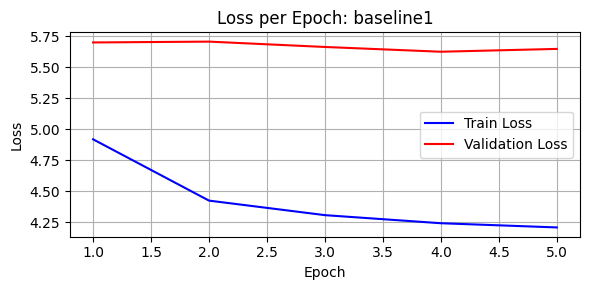

In [ ]:
# 저장된 모델과 학습 이력 불러오기
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)

# 같은 구조로 모델 재생성 후 state_dict 로드
load_baseline1 = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
load_baseline1.load_state_dict(checkpoint["model_state_dict"])

# 저장된 이력 중 loss history 가져오기
loss_history_loss_history_baseline1 = checkpoint2["loss_history"]
train_elapsed_time = checkpoint2["train_elapsed_time"]

#  베스트 모델 정보 출력
best_epoch = checkpoint["epoch"] + 1  
best_train_loss = checkpoint["train_loss"]
best_val_loss = checkpoint["val_loss"]
print(f"Best model was saved at Epoch {best_epoch}")
print(f"Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
print(f"Total training time : {train_elapsed_time:.2f} s")

# 그래프 그리기
plot_loss_epoch(model_type, loss_history_loss_history_baseline1)


In [ ]:
# 이제 Test 가능
Test(load_baseline1, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"])

Training batches:   0%|          | 0/17 [00:00<?, ?it/s]

[Batch 1/17] Loss: 5.6199
[Batch 2/17] Loss: 5.5173
[Batch 3/17] Loss: 5.6445
[Batch 4/17] Loss: 5.6818
[Batch 5/17] Loss: 5.7356
[Batch 6/17] Loss: 5.5516
[Batch 7/17] Loss: 5.5700
[Batch 8/17] Loss: 5.6573
[Batch 9/17] Loss: 5.3945
[Batch 10/17] Loss: 5.4296
[Batch 11/17] Loss: 5.7314
[Batch 12/17] Loss: 5.5915
[Batch 13/17] Loss: 5.6364
[Batch 14/17] Loss: 5.4893
[Batch 15/17] Loss: 5.7598
[Batch 16/17] Loss: 5.7112
[Batch 17/17] Loss: 5.8299


Evaluating Metrics:   0%|          | 0/17 [00:00<?, ?it/s]

Test Loss      : 5.6193
BLEU-4 Score   : 0.0371
METEOR Score   : 0.1711
BERTScore (F1) : 0.8249


(5.619320619337874, 0.0370714945481254, 0.171089240652591, 0.8249096274375916)

# Baseline2

model_type = "baseline2"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = run_train(model_type, config)


In [ ]:
model_type = "baseline2"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = run_train(model_type, config)


Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(8991, 128)
    (gru): GRU(128, 256, batch_first=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(8471, 256)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(256, 256, batch_first=True)
    (out): Linear(in_features=512, out_features=8471, bias=True)
  )
)
Training model: baseline2


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training batches:   0%|          | 0/2546 [00:00<?, ?it/s]

[Batch 1/2546] Loss: 9.0653
[Batch 2/2546] Loss: 8.9686
[Batch 3/2546] Loss: 8.8417
[Batch 4/2546] Loss: 8.4324
[Batch 5/2546] Loss: 8.0412
[Batch 6/2546] Loss: 7.6876
[Batch 7/2546] Loss: 7.1088
[Batch 8/2546] Loss: 6.8261
[Batch 9/2546] Loss: 6.4070
[Batch 10/2546] Loss: 6.1858
[Batch 11/2546] Loss: 6.0495
[Batch 12/2546] Loss: 6.0679
[Batch 13/2546] Loss: 6.2252
[Batch 14/2546] Loss: 6.0745
[Batch 15/2546] Loss: 6.0803
[Batch 16/2546] Loss: 6.0400
[Batch 17/2546] Loss: 6.0598
[Batch 18/2546] Loss: 6.1236
[Batch 19/2546] Loss: 6.0404
[Batch 20/2546] Loss: 6.0834
[Batch 21/2546] Loss: 5.9996
[Batch 22/2546] Loss: 6.2212
[Batch 23/2546] Loss: 6.0195
[Batch 24/2546] Loss: 6.1367
[Batch 25/2546] Loss: 6.0760
[Batch 26/2546] Loss: 5.9808
[Batch 27/2546] Loss: 6.0410
[Batch 28/2546] Loss: 6.0612
[Batch 29/2546] Loss: 5.9883
[Batch 30/2546] Loss: 5.9875
[Batch 31/2546] Loss: 5.9937
[Batch 32/2546] Loss: 5.9385
[Batch 33/2546] Loss: 5.9768
[Batch 34/2546] Loss: 5.8473
[Batch 35/2546] Loss: 5

KeyboardInterrupt: 

Best model was saved at Epoch 4
Train Loss: 3.9742 | Val Loss: 5.8047
Total training time : 15572.66 s


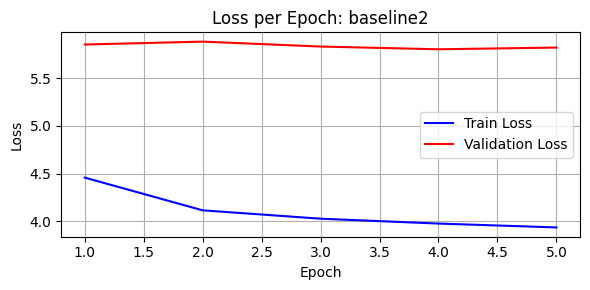

In [ ]:
# 저장된 모델과 학습 이력 불러오기
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)

# 같은 구조로 모델 재생성 후 state_dict 로드
load_baseline2 = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
load_baseline2.load_state_dict(checkpoint["model_state_dict"])

# 저장된 이력 중 loss history 가져오기
loss_history_loss_history_baseline2 = checkpoint2["loss_history"]
train_elapsed_time = checkpoint2["train_elapsed_time"]

#  베스트 모델 정보 출력
best_epoch = checkpoint["epoch"] + 1  
best_train_loss = checkpoint["train_loss"]
best_val_loss = checkpoint["val_loss"]
print(f"Best model was saved at Epoch {best_epoch}")
print(f"Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
print(f"Total training time : {train_elapsed_time:.2f} s")

# 그래프 그리기
plot_loss_epoch(model_type, loss_history_loss_history_baseline1)


In [ ]:
# 이제 Test 가능
Test(load_baseline1, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"])

/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)
Evaluating Metrics: 100%|██████████| 17/17 [00:23<00:00,  1.37s/it]


Test Loss      : 5.7656
BLEU-4 Score   : 0.0527
METEOR Score   : 0.2104
BERTScore (F1) : 0.8421


(5.76562103356177, 0.05269045547005537, 0.21038731724608936, 0.842138946056366)

# mild_extension1

In [ ]:
model_type = "mild_extension1"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = run_train(model_type, config)


Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(8991, 256)
    (gru): GRU(256, 512, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(8471, 512)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.5)
    (out): Linear(in_features=1024, out_features=8471, bias=True)
  )
)
Training model: mild_extension1


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training batches:   0%|          | 0/2546 [00:00<?, ?it/s]

/Users/jeeeunkim/Desktop/FIT5217_NLP/NLP/.venv/lib/python3.10/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


KeyboardInterrupt: 

In [ ]:
# 저장된 모델과 학습 이력 불러오기
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)

# 같은 구조로 모델 재생성 후 state_dict 로드
load_mild_extension1 = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
load_mild_extension1.load_state_dict(checkpoint["model_state_dict"])

# 저장된 이력 중 loss history 가져오기
loss_history_loss_history_mild_extension1 = checkpoint2["loss_history"]
train_elapsed_time = checkpoint2["train_elapsed_time"]

#  베스트 모델 정보 출력
best_epoch = checkpoint["epoch"] + 1  
best_train_loss = checkpoint["train_loss"]
best_val_loss = checkpoint["val_loss"]
print(f"Best model was saved at Epoch {best_epoch}")
print(f"Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
print(f"Total training time : {train_elapsed_time:.2f} s")

# 그래프 그리기
plot_loss_epoch(model_type, loss_history_loss_history_mild_extension1)


In [ ]:
# 이제 Test 가능
Test(load_mild_extension1, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"])

# mild_extension2

In [ ]:
model_type = "mild_extension2"
config = experiment_configs[model_type]

model, encoder, decoder, loss_history, save_model_path, save_history_path = run_train(model_type, config)


Seq2Seq(
  (encoder): Encoder_GRU(
    (embedding): Embedding(8991, 100)
    (gru): GRU(100, 512, num_layers=3, batch_first=True, dropout=0.5)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): AttnDecoderRNN(
    (embedding): Embedding(8471, 512)
    (dropout): Dropout(p=0.5, inplace=False)
    (gru): GRU(512, 512, num_layers=3, batch_first=True, dropout=0.5)
    (out): Linear(in_features=1024, out_features=8471, bias=True)
  )
)
Training model: mild_extension2


Epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5


Training batches:   0%|          | 0/2546 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# 저장된 모델과 학습 이력 불러오기
checkpoint = torch.load(save_model_path, map_location=DEVICE)
checkpoint2 = torch.load(save_history_path, map_location=DEVICE)

# 같은 구조로 모델 재생성 후 state_dict 로드
load_mild_extension2 = Seq2Seq(encoder, decoder, DEVICE, use_attention=config["USE_ATTENTION"]).to(DEVICE)
load_mild_extension2.load_state_dict(checkpoint["model_state_dict"])

# 저장된 이력 중 loss history 가져오기
loss_history_loss_history_mild_extension2 = checkpoint2["loss_history"]
train_elapsed_time = checkpoint2["train_elapsed_time"]

#  베스트 모델 정보 출력
best_epoch = checkpoint["epoch"] + 1  
best_train_loss = checkpoint["train_loss"]
best_val_loss = checkpoint["val_loss"]
print(f"Best model was saved at Epoch {best_epoch}")
print(f"Train Loss: {best_train_loss:.4f} | Val Loss: {best_val_loss:.4f}")
print(f"Total training time : {train_elapsed_time:.2f} s")

# 그래프 그리기
plot_loss_epoch(model_type, loss_history_loss_history_mild_extension2)


In [ ]:
# 이제 Test 가능
Test(load_mild_extension2, test_loader, criterion, recipe_vocab, MAX_LEN=config["MAX_LEN"])

# Plot for all model

In [ ]:
plot_loss_iter(
    baseline1=loss_history_loss_history_baseline1,
    baseline2=loss_history_loss_history_baseline2
)


# Generator

In [ ]:
def generate_recipes(ingredient_list, ingredient_vocab, recipe_vocab, max_len=30, is_raw_string=False, **models):

    # Tokenizer 적용 여부
    if is_raw_string:
        tokens = tokenizer_ingredient(str(ingredient_list))
    else:
        tokens = ingredient_list

    # index로 변환
    tokens_ids = [ ingredient_vocab[token] if token in ingredient_vocab else ingredient_vocab['<unk>'] for token in tokens]
    src_tensor = torch.tensor(tokens_ids, dtype=torch.long, device=DEVICE).unsqueeze(0)

    print("Ingredient :",', '.join(tokens))
    for name, model in models.items():
        model.eval()
        with torch.no_grad():
            generated = model(src_tensor, target=None, teacher_forcing_ratio=0.0, max_len=max_len)
            pred_ids = generated[0].tolist()

            # <eos> 기준으로 자르기
            if recipe_vocab['<eos>'] in pred_ids:
                pred_ids = pred_ids[:pred_ids.index(recipe_vocab['<eos>'])]

            pred_tokens = [recipe_vocab.get_itos()[idx] for idx in pred_ids]
            print(f"{name}: {' '.join(pred_tokens[:30])}")
    print("-" * 100)

    

In [ ]:
models = {
    "baseline1": load_baseline1,
    # "baseline2": load_baseline2
}

# # Sample 1: 전처리된 리스트
sample1_raw = "sugar, lemon juice,  water,  orange juice, strawberries, icecream"
sample1 = sample1_raw.split(", ")
generate_recipes(sample1, ingredient_vocab, recipe_vocab, is_raw_string=False, **models)

# Sample2 : 
sample2_raw ="8 oz philadelphia cream cheese, 14 oz can sweetened condensed milk, 1 ts vanilla, 1/3 c  lemon juice, 48 oz canned cherries, 8 inch graham cracker,  pie crusts"
sample2 = sample2_raw.split(", ")
generate_recipes(sample2, ingredient_vocab, recipe_vocab, is_raw_string=True, **models)

Ingredient : sugar, lemon juice,  water,  orange juice, strawberries, icecream
baseline1: and sugar and vanilla and pour into a 9 x 13 inch pan
----------------------------------------------------------------------------------------------------
Ingredient : philadelphia, cream, cheese, sweetened, condensed, milk, ts, vanilla,  , lemon, juice, canned, cherries, graham, cracker,  , pie, crusts
baseline1: cream cheese and vanilla and vanilla in a large bowl add vanilla and vanilla mix well and pour into a 9 x 13 inch pan
----------------------------------------------------------------------------------------------------


In [ ]:
##### 예전꺼(결과있음!!!) #####
def compute_bleu(model, dataloader, recipe_vocab, max_len=50):
    """
    Seq2Seq 모델의 BLEU 점수를 계산 (1~4-gram 기준)

    Args:
        model: 학습된 Seq2Seq 모델
        dataloader: 검증 또는 테스트 DataLoader
        recipe_vocab: recipe vocab 객체 (인덱스 → 단어 변환용)
        max_len: 생성할 최대 문장 길이

    Returns:
        bleu_score (float): 0~100 사이의 BLEU 점수
    """
    model.eval()
    preds = []
    targets = []

    with torch.no_grad():
        for src_batch, trg_batch in tqdm(dataloader, desc="Evaluating BLEU"):
            src_batch = src_batch.to(DEVICE)
            trg_batch = trg_batch.to(DEVICE)

            # 생성된 예측 시퀀스: [batch_size, max_len]
            generated = model(src_batch, target=None, teacher_forcing_ratio=0.0, max_len=max_len)

            for i in range(src_batch.size(0)):
                pred_tokens = generated[i].tolist()
                trg_tokens = trg_batch[i].tolist()

                # <eos> 토큰이 나오면 거기서 자름
                if recipe_vocab['<eos>'] in pred_tokens:
                    pred_tokens = pred_tokens[:pred_tokens.index(recipe_vocab['<eos>'])]
                if recipe_vocab['<eos>'] in trg_tokens:
                    trg_tokens = trg_tokens[:trg_tokens.index(recipe_vocab['<eos>'])]

                preds.append(pred_tokens)
                targets.append([trg_tokens])  # corpus_bleu는 list of list 필요

    bleu = corpus_bleu(targets, preds) * 100
    print(f"\nBLEU Score: {bleu:.2f}")
    return bleu


def loss_epoch(model, dataloader, criterion, optimizer=None, teacher_forcing_ratio=0.5):
    """
    학습 또는 평가 루프에서 1 epoch 동안 loss만 계산하는 함수.

    Args:
        model: Seq2Seq 모델
        dataloader: DataLoader
        criterion: 손실 함수 (CrossEntropyLoss)
        optimizer: 옵티마이저 (None이면 eval 모드로 동작)
        teacher_forcing_ratio: 학습 중 Teacher Forcing 비율

    Returns:
        epoch_loss: 전체 데이터셋에 대한 평균 loss
    """
    model.train() if optimizer else model.eval()
    rloss = 0

    for src_batch, trg_batch in tqdm(dataloader, leave=False):
        src_batch = src_batch.to(DEVICE)
        trg_batch = trg_batch.to(DEVICE)

        output = model(src_batch, trg_batch, teacher_forcing_ratio=teacher_forcing_ratio)
        output_dim = output.shape[-1]

        # CrossEntropyLoss 계산을 위한 reshape
        output = output[:, 1:, :].reshape(-1, output_dim)
        trg = trg_batch[:, 1:].reshape(-1)

        loss = criterion(output, trg)

        if optimizer:
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
            optimizer.step()

        rloss += loss.item() * src_batch.shape[0]

    return rloss / len(dataloader.dataset)

def Train(model, train_loader, val_loader, criterion, optimizer,
          EPOCHS, BATCH_SIZE, TRAIN_RATIO,
          save_model_path, save_history_path,
          ):
    """
    이어서 학습할 수 있게 start_epoch와 best_val_loss를 인자로 받음
    """

    loss_history = {"train": [], "val": []}
    best_val_loss = float('inf')
    train_start_time = time.time()
    for epoch in range(EPOCHS):
        print(f"\nEpoch {epoch+1}/{EPOCHS}")

        ep_start_time = time.time()

        # Training
        train_loss = loss_epoch(model, train_loader, criterion, optimizer, teacher_forcing_ratio=0.5)
        loss_history["train"].append(train_loss)

        # Validation
        val_loss = loss_epoch(model, val_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0)
        loss_history["val"].append(val_loss)

        ep_elapsed_time = time.time() - ep_start_time

        # Save best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save({
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch,
                "val_loss": val_loss,
                "train_loss": train_loss,  # train_loss 저장
            }, save_model_path)
            print("Best model saved!")

        print(f"Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Time: {ep_elapsed_time:.2f}s")
    train_elapsed_time = time.time() - train_start_time
    # Save training history
    torch.save({
        "loss_history": loss_history,
        "EPOCHS": EPOCHS,
        "BATCH_SIZE": BATCH_SIZE,
        "TRAIN_RATIO": TRAIN_RATIO
    }, save_history_path)

    print(f"\nTraining Completed! History saved!| Elapsed Time : {train_elapsed_time}")
    return loss_history


def Test(model, test_loader, criterion, recipe_vocab):
    """
    테스트 데이터셋에서 손실과 BLEU 점수를 계산하는 함수.

    Args:
        model: 학습된 Seq2Seq 모델
        test_loader: 테스트 DataLoader
        criterion: 손실 함수
        recipe_vocab: vocab 객체 (BLEU 계산용)

    Returns:
        test_loss (float), bleu_score (float)
    """
    print("\n Testing on test set...")
    model.eval()

    with torch.no_grad():
        test_loss = loss_epoch(model, test_loader, criterion, optimizer=None, teacher_forcing_ratio=0.0)

    bleu_score = compute_bleu(model, test_loader, recipe_vocab)
    print(f"Test Loss: {test_loss:.4f} | BLEU Score: {bleu_score:.2f}")

    return test_loss, bleu_score




New model training!

Epoch 1/10


  0%|          | 0/2546 [00:00<?, ?it/s]/home/psarda/repos/NLP/.venv/lib/python3.11/site-packages/spacy/pipeline/lemmatizer.py:211: UserWarning: [W108] The rule-based lemmatizer did not find POS annotation for one or more tokens. Check that your pipeline includes components that assign token.pos, typically 'tagger'+'attribute_ruler' or 'morphologizer'.
  warnings.warn(Warnings.W108)


Best model saved!
Train Loss: 4.3775 | Val Loss: 4.9679 | Time: 3727.94s

Epoch 2/10


Best model saved!
Train Loss: 3.9285 | Val Loss: 4.9464 | Time: 3716.95s

Epoch 3/10


Best model saved!
Train Loss: 3.8209 | Val Loss: 4.8882 | Time: 3724.51s

Epoch 4/10


Train Loss: 3.7594 | Val Loss: 4.8932 | Time: 3715.59s

Epoch 5/10


Train Loss: 3.7219 | Val Loss: 4.9373 | Time: 3987.15s

Epoch 6/10


Train Loss: 3.6916 | Val Loss: 4.8978 | Time: 3766.76s

Epoch 7/10


Train Loss: 3.6670 | Val Loss: 4.9374 | Time: 3943.18s

Epoch 8/10


Train Loss: 3.6451 | Val Loss: 4.8948 | Time: 4250.35s

Epoch 9/10


Train Loss: 3.6278 | Val Loss: 4.9209 | Time: 4195.73s

Epoch 10/10


Train Loss: 3.6148 | Val Loss: 4.9444 | Time: 4038.07s

Training Completed! History saved!| Elapsed Time : 39066.561606884


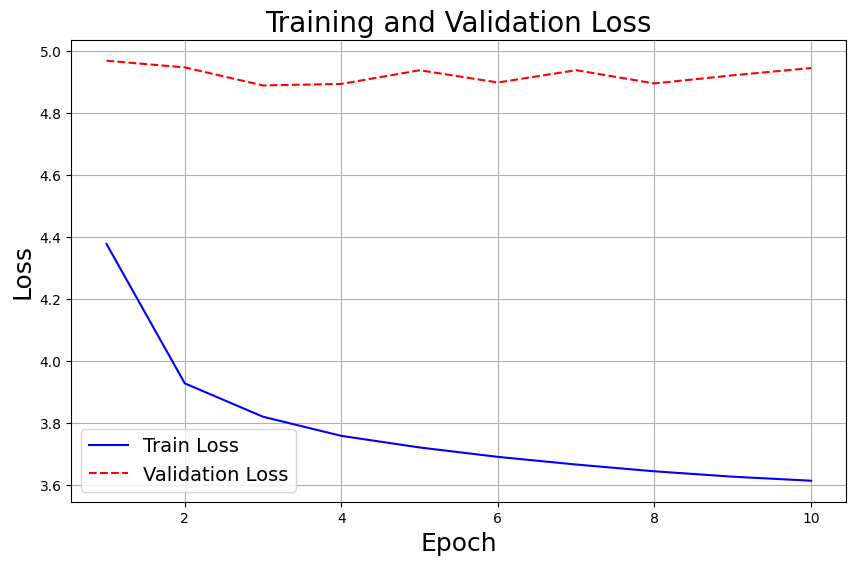

In [ ]:
##### 예전꺼(결과있음!!!) #####

# 모델 생성
encoder = Encoder_GRU(INPUT_DIM, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
decoder = Decoder_GRU(OUTPUT_DIM, EMBED_DIM, HIDDEN_DIM, N_LAYERS, DROPOUT)
model = Seq2Seq(encoder, decoder, DEVICE).to(DEVICE)

if new_model_train:
    print("New model training!")
    optimizer = optim.Adam(model.parameters(), lr=LR)

    loss_history = Train(
        model=model,
        train_loader=train_loader,
        val_loader=dev_loader,
        criterion=criterion,
        optimizer=optimizer,
        EPOCHS=EPOCHS,
        BATCH_SIZE=BATCH_SIZE,
        TRAIN_RATIO=TRAIN_RATIO,
        save_model_path=save_model_path,
        save_history_path=save_history_path,
    )

    # 플롯 그리기
    plt.figure(figsize=(10,6))
    plt.plot(range(1, EPOCHS+1), loss_history["train"], label="Train Loss", color="blue")
    plt.plot(range(1, EPOCHS+1), loss_history["val"], label="Validation Loss", color="red", linestyle='--')
    plt.xlabel("Epoch", fontsize=18)
    plt.ylabel("Loss", fontsize=18)
    plt.title("Training and Validation Loss", fontsize=20)
    plt.legend(fontsize=14)
    plt.grid()
    plt.show()
